# Código para a segmentação de dados de um dataframe

O primeiro passo é importar os dados de um arquivo .csv

O exemplo usado para isso é o arquivo run8.csv, que possui dados emg medidos, além da alguns dados inerciais. 
Como, por enquanto, só nos interessa o valor EMG medido, ao se ler o csv, utiliza-se apenas as colunas do tempo de medição, que vai servir como índicie, e do emg medido. 

Utiliza-se uma frequência de 1000Hz para a coleta dos dados, o que fornece 1 amostra por milissegundo. O tempo total da coleta é feito por 21,6 segundos, totalizando 21600 medições. 

In [3]:
import numpy as np
import pandas as pd
from pandas import read_csv
# series = read_csv('/home/raphael/Desktop/TCC_UnB/data/run8.csv', header=46, usecols = [0,1], index_col = 0) 
# series = read_csv('/home/raphael/Desktop/TCC_UnB/data/run6.csv', header=32, usecols = [0,1], index_col = 0)
# series = read_csv('/home/raphael/Desktop/TCC_UnB/data/train/close_hand_1.csv', header=1, usecols = [0,1], index_col = 0)
series = read_csv('https://raw.githubusercontent.com/raphaelrcb/TCC_UnB/raphael_dev/data/v0/gesture_1_2.csv', header=1, usecols = [0,1], index_col = 0)
series.head()

,Avanti Sensor 1: EMG 1->RMean->Subset [V]
X [s],
0.000,2.471585e-07
0.001,2.597049e-06
0.002,2.261351e-06
0.003,7.632525e-06
0.004,6.289732e-06


# Indexação dos dados

Ao ler o csv, o framework pandas já converte os dados em um DataFrame. Este DataFrame, como visto acima, utiliza como índice o tempo da medição (em ms) e a colunda de dados é a medição EMG (em Volts). 

Porém, as funções que vão ser usadas a seguir não entendem os valores do índice na forma que foram lidos, e por isso deve-se fazer uma conversão dos dados para que sejam entendidos

In [2]:
series.index = pd.to_datetime(series.index, unit = 's', origin= 'unix')
series.index = series.index.map(lambda t: t.replace(year=2021, month=10, day=12, hour=10))
series.index = pd.DatetimeIndex(series.index).to_period('L') 
series.head()


,Avanti Sensor 1: EMG 1->RMean->Subset [V]
X [s],
2021-10-12 10:00:00.000,2.471585e-07
2021-10-12 10:00:00.001,2.597049e-06
2021-10-12 10:00:00.002,2.261351e-06
2021-10-12 10:00:00.003,7.632525e-06
2021-10-12 10:00:00.004,6.289732e-06


# Segmentação dos Dados

$$
N\; janelas = \frac{tamanho\: dos\,dados - tamanho\, da\, janela}{incremento\, da\,janela} + 1
$$

In [4]:
data_size = len(series)
window_size = 150
window_overlap = 50

n_windows = (data_size - window_size)/window_overlap + 1

osw = []
for i in range(int(n_windows)):
    osw.append( series[(i*window_overlap):(i*window_overlap + window_size)])

osw[0].head()


,Avanti Sensor 1: EMG 1->RMean->Subset [V]
X [s],
2021-10-12 10:00:00.000,2.471585e-07
2021-10-12 10:00:00.001,2.597049e-06
2021-10-12 10:00:00.002,2.261351e-06
2021-10-12 10:00:00.003,7.632525e-06
2021-10-12 10:00:00.004,6.289732e-06


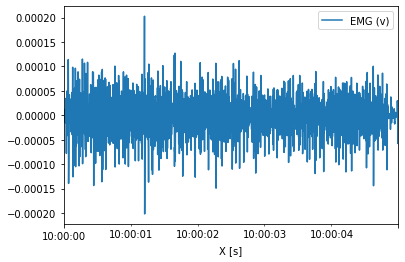

In [5]:
%matplotlib inline
from matplotlib import pyplot
series.plot()
pyplot.legend(['EMG (v)'])

# Teste ADFULLER para testar estacionaridade

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -21.021502
p-value: 0.000000


# Contruindo modelo ARIMA

In [7]:
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(osw[51], order = (4,0,0))
model_fit = model.fit(method='yule_walker')
print(model_fit.summary())

                                           SARIMAX Results                                           
Dep. Variable:     Avanti Sensor 1: EMG 1->RMean->Subset [V]   No. Observations:                  150
Model:                                        ARIMA(4, 0, 0)   Log Likelihood                1422.980
Date:                                       Thu, 21 Oct 2021   AIC                          -2833.960
Time:                                               19:26:36   BIC                          -2815.896
Sample:                                           10-12-2021   HQIC                         -2826.621
                                                - 10-12-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.806e-07    4

# Plotando erros residuais

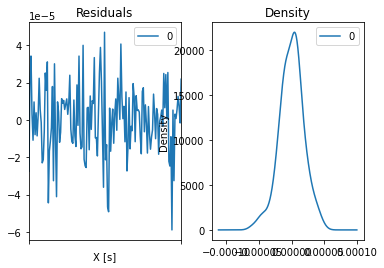

In [8]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = pyplot.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
pyplot.show()

# Predição

In [9]:


# Actual vs Fitted
# Uses older version of statsmodel
model_fit.plot_predict(dynamic=False)
pyplot.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [10]:
feature_vector = []
feature_vector.append(model_fit.polynomial_ar)
feature_vector = np.delete(feature_vector, 0)
feature_vector = -feature_vector
np.delete(model_fit.polynomial_ar, 0)
print(feature_vector)

[ 1.30176431 -0.9076929   0.15937552  0.07240135]


/home/raphael/Desktop/TCC_UnB/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


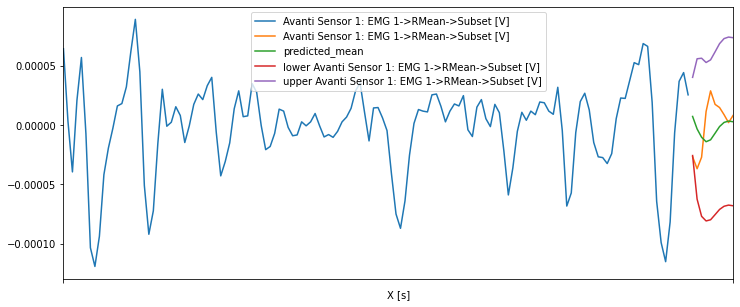

In [18]:
from statsmodels.tsa.stattools import acf 

#Separar dados em treinamento e teste
#51 foi o melhor entre eles
treino = osw[75][:140]
teste = osw[75][140:]
treino.head()
# teste.head()

#Construir Modelo
modelo = ARIMA(treino, order=(4,0,0))
ajuste = modelo.fit()

#Forecast
fc = ajuste.get_forecast(10)
fc_series = fc.predicted_mean

#build confiance interval 
fc_conf = fc.conf_int(alpha=0.05)
conf_low = pd.DataFrame(fc_conf[fc_conf.columns[0]])
conf_upp = pd.DataFrame(fc_conf[fc_conf.columns[1]])


#Plot

# x = np.arange(0, (len(treino)+len(teste)), 1)
# fig, ax = pyplot.subplots(1,1)
# ax.plot(x,treino.values)

# pd.plotting.register_matplotlib_converters()
# pyplot.figure(figsize=(12,5), dpi=100)
ax = treino.plot( figsize=(12,5))
teste.plot(ax=ax)
fc_series.plot(ax=ax, legend = 'forecast')
conf_low.plot(ax=ax)
conf_upp.plot(ax=ax)
# pyplot.plot(treino, label='treinamento')
# treino.plot(label = "treinamento")
# teste.plot(label = "teste")
# pyplot.plot(teste, label='real')
# pyplot.plot(fc_series, label='forecast')
# pyplot.fill_between(conf_low.index, conf_low, conf_upp, color='k', alpha=.15)
# pyplot.title("Previsão vs Real")
# pyplot.legend(loc='upper left', fontsize=8)
pyplot.show()